In [2]:
import sys
sys.path.append("/content/drive/My Drive/tsai/tsai_repo")

In [27]:
import torch
import albumentations as A
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt

In [28]:
from data_transformations.transform import AlbumentationTransforms
from data_loader.data_loader_cifar import dataLoader


In [29]:
#Load the model
model = torch.load('/content/drive/My Drive/Models/model_s10')
model.eval()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [30]:
#Transforms
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])
dataloader = dataLoader()
test_loader = dataloader.get_train_loader(test_transforms)
classes = dataloader.get_classes()

CUDA is available: True
Initiated Data Loader with: {'shuffle': True, 'batch_size': 128, 'num_workers': 4, 'pin_memory': True}
Files already downloaded and verified


In [31]:
def misclassified(model, test_loader, device):
    with torch.no_grad():
        for_the_first_time = 1
        prediction_list = []
        actual_list = []
        for data, target in test_loader:
            actual_list = actual_list + list(np.array(target.cpu()))
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            prediction_list = prediction_list+list(np.array(pred.cpu().reshape(len(target))))
            predicted_val = pred[target.view_as(pred) != pred]
            actual_val = target.view_as(pred)[target.view_as(pred) != pred]
            misclass_img = data[(target.view_as(pred) != pred).view_as(target)]

            if for_the_first_time == 1:
                misclass_data = misclass_img
                misclass_targets = actual_val
                misclass_preds = predicted_val
                for_the_first_time = 0
            elif for_the_first_time == 0:
                # one mis classified image already found now just append anymore
                misclass_data = torch.cat([misclass_data, misclass_img], dim=0)
                misclass_targets = torch.cat([misclass_targets, actual_val], dim=0)
                misclass_preds = torch.cat([misclass_preds, predicted_val], dim=0)
                # if len(misclass_data > 25):
                #     break
            else:
                print("No Mis Classifications")
            
    return misclass_data, misclass_targets, misclass_preds, actual_list, prediction_list

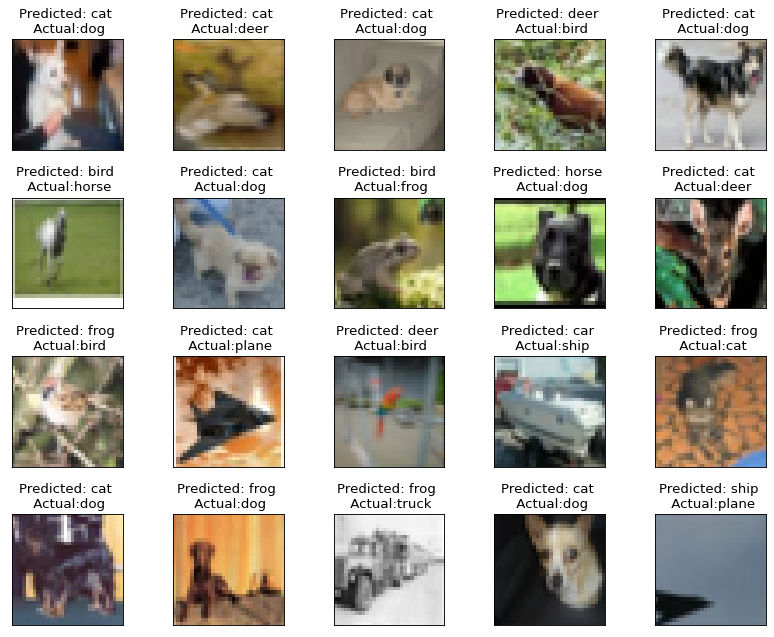

In [32]:
misclass_data_r, misclass_targets_r,misclass_pred_r, actuals, predictions = misclassified(model,test_loader,device)
from matplotlib.pyplot import figure
from utils import denormalize
fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
misclass_targets_r_cpu = misclass_targets_r.cpu().numpy()
misclass_pred_r_cpu = misclass_pred_r.cpu().numpy()
for num in range(0,20):
    plt.subplot(5,5,num+1)
    plt.tight_layout()
    mis_class_img = misclass_data_r[num]
    mis_class_img_cpu = mis_class_img.cpu()
    plt_image = denormalize(mis_class_img_cpu,channel_means,channel_stdevs)
    plt_image = np.transpose(plt_image, (1, 2, 0))
    plt_image = np.uint8(255*plt_image)
    plt.imshow(plt_image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted: {} \n Actual:{}".format(
    classes[misclass_pred_r_cpu[num]], classes[misclass_targets_r_cpu[num]]))

In [33]:
def show_accuracy_report(actuals, predictions):
    # print(len(actuals),len(predictions))
    print(classification_report(actuals, 
                                predictions,
                                target_names=classes))
    cm = confusion_matrix(actuals,predictions)
    cm = pd.DataFrame(cm , index = classes , columns = classes)
    cm
    plt.figure(figsize = (10,10))
    labels = classes
    sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

              precision    recall  f1-score   support

       plane       0.85      0.86      0.85      5000
         car       0.91      0.95      0.93      5000
        bird       0.84      0.71      0.77      5000
         cat       0.57      0.83      0.68      5000
        deer       0.71      0.88      0.79      5000
         dog       0.92      0.51      0.66      5000
        frog       0.77      0.89      0.82      5000
       horse       0.90      0.82      0.86      5000
        ship       0.90      0.89      0.89      5000
       truck       0.98      0.77      0.86      5000

    accuracy                           0.81     50000
   macro avg       0.83      0.81      0.81     50000
weighted avg       0.83      0.81      0.81     50000



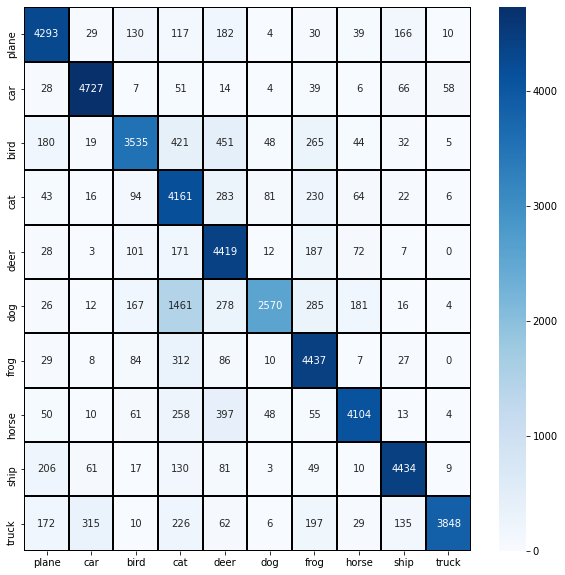

In [34]:
show_accuracy_report(actuals, predictions)